# **chromaVive:** Colorful Image Colorization Model

**NOTE:** 
As individuals with limited GPU power and computational resources, it is not feasible for us to replicate the extensive work done by Richard Zhang et al. in their seminal paper *"Colorful Image Colorization"* (ECCV 2016). However, we provide a **proof of concept** to demonstrate the fundamental approach to tackling the image colorization problem.

## **Color Space Conversion:** RGB & LAB

#### System Variables

In [1]:
IMG_PATH = 'image.jpeg'

#### Libraries Import

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

#### *Original Image:* BGR to RGB

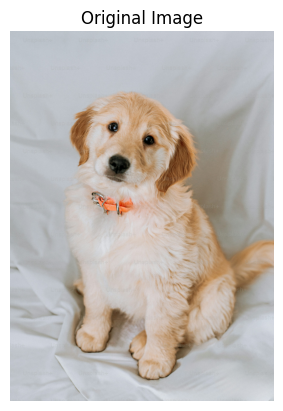

In [3]:
img = cv.imread(IMG_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show();

#### *Original Image:* BGR to LAB

In [4]:
img = cv.imread(IMG_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
L, a, b = cv.split(img)

ab_ = cv.merge([np.zeros_like(L), a, b])

#### *LAB Color Space:* Lightness (L), Green-Red (a), Blue-Yellow (b)

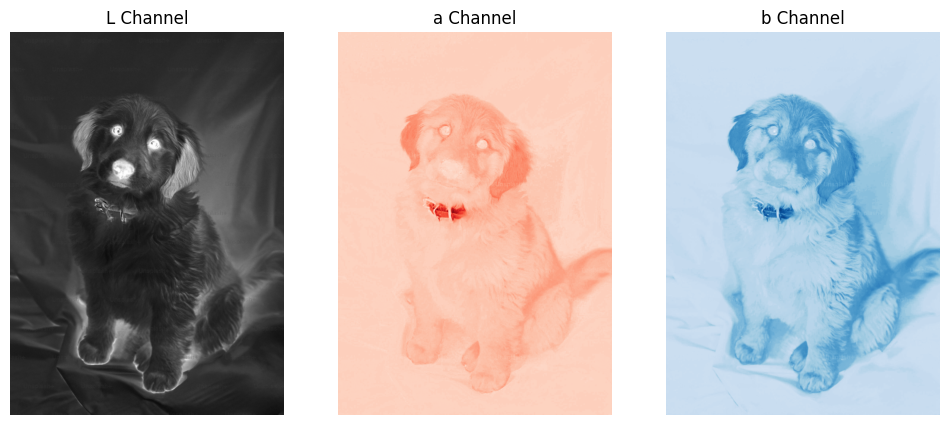

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(L, cmap='binary')
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(a, cmap='Reds')
ax[1].set_title('a Channel')
ax[1].axis('off')

ax[2].imshow(b, cmap='Blues')
ax[2].set_title('b Channel')
ax[2].axis('off')

plt.show();

#### *LAB Color Space:* Lightness (L), Green-Red-Blue-Yellow (ab)

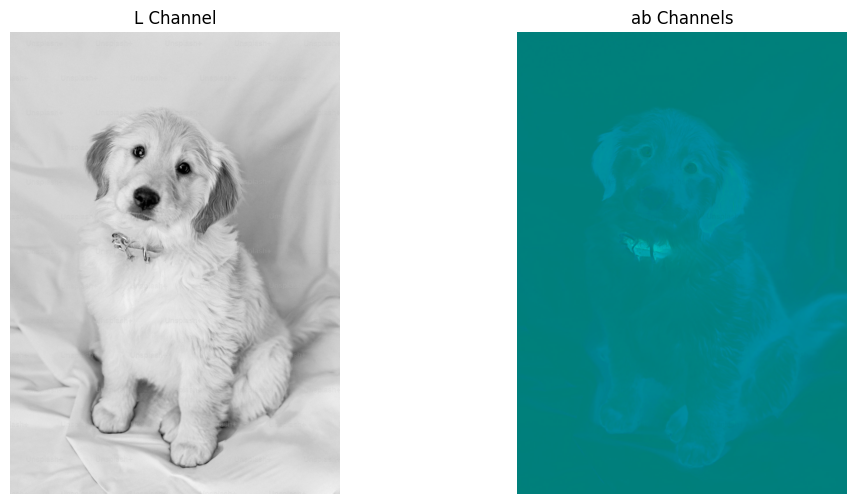

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(L, cmap='gray')
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(ab_, cmap='Wistia')
ax[1].set_title('ab Channels')
ax[1].axis('off')

plt.show();

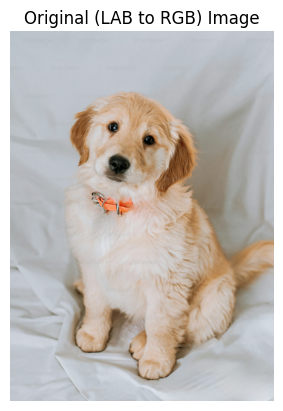

In [7]:
lab = cv.merge([L, a, b])
merged_img = cv.cvtColor(lab, cv.COLOR_LAB2RGB)
plt.imshow(merged_img)
plt.title('Original (LAB to RGB) Image')
plt.axis('off')
plt.show();

In [8]:
L, a, b

(array([[178, 184, 190, ..., 204, 201, 198],
        [181, 186, 193, ..., 206, 203, 200],
        [186, 191, 196, ..., 207, 204, 202],
        ...,
        [191, 191, 194, ..., 201, 197, 197],
        [181, 184, 189, ..., 196, 192, 189],
        [178, 182, 188, ..., 195, 189, 183]],
       shape=(4206, 3000), dtype=uint8),
 array([[123, 123, 124, ..., 128, 128, 128],
        [123, 123, 124, ..., 128, 128, 128],
        [125, 125, 125, ..., 128, 128, 128],
        ...,
        [125, 125, 126, ..., 127, 128, 128],
        [125, 125, 125, ..., 128, 128, 128],
        [125, 125, 125, ..., 128, 129, 129]],
       shape=(4206, 3000), dtype=uint8),
 array([[126, 126, 125, ..., 123, 123, 123],
        [126, 126, 125, ..., 123, 123, 123],
        [125, 125, 125, ..., 123, 123, 123],
        ...,
        [129, 129, 129, ..., 128, 128, 129],
        [131, 130, 130, ..., 129, 129, 130],
        [131, 131, 130, ..., 129, 130, 130]],
       shape=(4206, 3000), dtype=uint8))

## **Bin Classification:** AB Color Space 

#### System Variables

In [9]:
k = 5
grid_size = 16

#### Libraries Import

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#### Bin Classification: a and b channels

In [11]:
def create_ab_bins(grid_size=16):
    a_range = torch.arange(-128 + grid_size // 2, 128, grid_size, dtype=torch.float32)
    b_range = torch.arange(-128 + grid_size // 2, 128, grid_size, dtype=torch.float32)
    ab_bins = torch.tensor([[a, b] for a in a_range for b in b_range])

    return ab_bins

In [12]:
ab_bins = create_ab_bins(grid_size)
print(f'No. of bins: {ab_bins.shape[0]}')
print(f'ab_bins shape: {[ab_bins.shape[i] for i in range(len(ab_bins.shape))]}')

No. of bins: 256
ab_bins shape: [256, 2]


In [13]:
ab_bins

tensor([[-120., -120.],
        [-120., -104.],
        [-120.,  -88.],
        [-120.,  -72.],
        [-120.,  -56.],
        [-120.,  -40.],
        [-120.,  -24.],
        [-120.,   -8.],
        [-120.,    8.],
        [-120.,   24.],
        [-120.,   40.],
        [-120.,   56.],
        [-120.,   72.],
        [-120.,   88.],
        [-120.,  104.],
        [-120.,  120.],
        [-104., -120.],
        [-104., -104.],
        [-104.,  -88.],
        [-104.,  -72.],
        [-104.,  -56.],
        [-104.,  -40.],
        [-104.,  -24.],
        [-104.,   -8.],
        [-104.,    8.],
        [-104.,   24.],
        [-104.,   40.],
        [-104.,   56.],
        [-104.,   72.],
        [-104.,   88.],
        [-104.,  104.],
        [-104.,  120.],
        [ -88., -120.],
        [ -88., -104.],
        [ -88.,  -88.],
        [ -88.,  -72.],
        [ -88.,  -56.],
        [ -88.,  -40.],
        [ -88.,  -24.],
        [ -88.,   -8.],
        [ -88.,    8.],
        [ -88., 

#### *AB Bin Classification:* Visualization

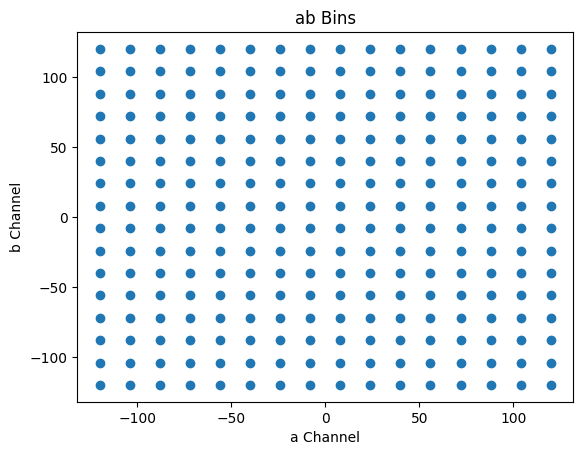

In [14]:
plt.plot(ab_bins[:, 0], ab_bins[:, 1], 'o')
plt.xlabel('a Channel')
plt.ylabel('b Channel')
plt.title('ab Bins')
plt.show();

#### *K-nearest bins*: Implementation

In [15]:
def k_nearest_neighbours(ab_target, ab_reference, k=5):
    """
    Find the k nearest neighbors in the ab color space to a target point.

    Parameters:
    ----------
    ab_target : torch.Tensor
        Target point in the form of (a, b).

    ab_reference : torch.Tensor
        Reference points, shape (n, 2).

    k : int, optional
        Number of nearest neighbors to find (default is 5).

    Returns:
    -------
    torch.Tensor
        k nearest points in the ab color space.

    torch.Tensor
        Distances of the k nearest points from the target.
    """

    ab_target = ab_target.float()
    ab_reference = ab_reference.float()

    distances = torch.linalg.norm(ab_reference - ab_target, dim=1)  # (n, ) L2 distances
    k_distances = torch.argsort(distances)[:k]
    return k_distances, distances[k_distances]

def gaussian_encoding(ab_target, ab_reference, k=5, std_dev=5.0):
    """
    Calculate Gaussian weights for ab_reference based on distance to ab_target.

    Parameters:
    ----------
    ab_target : torch.Tensor
        Target point in the form of (a, b).

    ab_reference : torch.Tensor
        Reference points, shape (n, 2).

    std_dev : float, optional
        Standard deviation for the Gaussian distribution (default is 5.0).

    Returns:
    -------
    torch.Tensor
        Normalized Gaussian weights for each reference point.
    """

    k_distances_indices, k_distance_values = k_nearest_neighbours(ab_target, ab_reference, k)
    weights = torch.exp(-0.5 * ((k_distance_values / std_dev) ** 2))    # (k, ) gaussian encoding
    soft_weights = weights / torch.sum(weights)                         # (k, ) normalized weights

    n = ab_reference.shape[0]
    soft_weights_encoded = torch.zeros(n)                               # (n, ) encoded weights
    soft_weights_encoded[k_distances_indices] = soft_weights

    return soft_weights_encoded

In [16]:
ab_target = torch.randint(-128, 128, (2, ))
soft_encoded_weights = gaussian_encoding(ab_target, ab_bins, k)
soft_encoded_weights

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0110, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [17]:
print(f'Sum of weights: {soft_encoded_weights.sum():.4f}')
print(f'Max weight: {soft_encoded_weights.max():.4f}')
print(f'Min weight: {soft_encoded_weights.min():.4f}')
print(f'Soft Encoded Weights\' shape: {soft_encoded_weights.shape[0]}')

Sum of weights: 1.0000
Max weight: 0.9718
Min weight: 0.0000
Soft Encoded Weights' shape: 256


#### *K-nearest bins*: Visualization

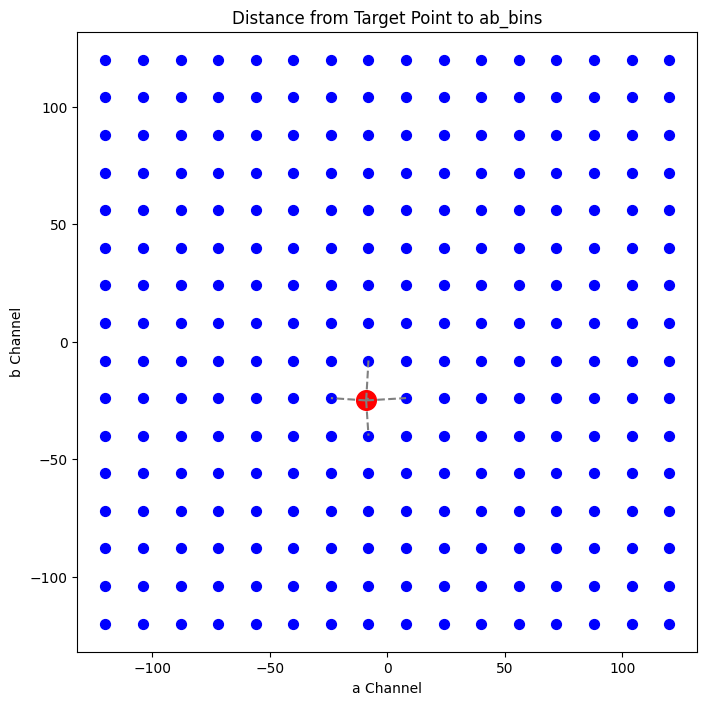

In [18]:
plt.figure(figsize=(8, 16))
plt.scatter(ab_bins[:, 0], ab_bins[:, 1], color='blue', s=50)
plt.scatter(ab_target[0], ab_target[1], color='red', s=200)
for i in range(len(ab_bins)):
    plt.plot([ab_target[0], ab_bins[i, 0]], [ab_target[1], ab_bins[i, 1]], color='gray', linestyle='--') if soft_encoded_weights[i] > 0 else None
plt.title('Distance from Target Point to ab_bins')
plt.xlabel('a Channel')
plt.ylabel('b Channel')
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## **ImageNet**: Downscaled Versions

#### System Variables

In [19]:
img_size = 8
path = f'./datasets/ImageNet {img_size}X{img_size}/Imagenet#_train'
extraction_path = f'datasets/extracted/LABEL/imagenet#_data_batch_'

#### Libraries Import

In [20]:
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### ImageNet Extraction

In [21]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [22]:
def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=X_train.astype('float32'),
        Y_train=Y_train.astype('int32'),
        mean=mean_image)

#### *ImageNet Local*: Inception & Extraction

In [23]:
count = 0
for i in range(10):
    print(f'Loading batch {i+1}...')
    data = load_databatch(path.replace('#', str(img_size)), i+1, img_size)

    if not os.path.exists('./datasets/extracted/X_train'):
        os.makedirs('./datasets/extracted/X_train')

    if not os.path.exists('./datasets/extracted/Y_train'):
        os.makedirs('./datasets/extracted/Y_train')

    if not os.path.exists('./datasets/extracted/mean'):
        os.makedirs('./datasets/extracted/mean')
        
    image_count = data['X_train'].shape[0]
    print(f'Loaded batch: {i+1} with {image_count} images')

    print('Saving data...')
    np.save(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'X_train')}{i+1}.npy", data['X_train'])     # X_train: (N, C, H, W)
    np.save(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'Y_train')}{i+1}.npy", data['Y_train'])     # Y_train: (N, )
    np.save(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'mean')}{i+1}.npy", data['mean'])           # mean: (C * H * W, )

    count += image_count

print(f'Total images: {count}')

Loading batch 1...
Loaded batch: 1 with 256232 images
Saving data...
Loading batch 2...
Loaded batch: 2 with 256232 images
Saving data...
Loading batch 3...
Loaded batch: 3 with 256232 images
Saving data...
Loading batch 4...
Loaded batch: 4 with 256232 images
Saving data...
Loading batch 5...
Loaded batch: 5 with 256232 images
Saving data...
Loading batch 6...
Loaded batch: 6 with 256232 images
Saving data...
Loading batch 7...
Loaded batch: 7 with 256232 images
Saving data...
Loading batch 8...
Loaded batch: 8 with 256232 images
Saving data...
Loading batch 9...
Loaded batch: 9 with 256232 images
Saving data...
Loading batch 10...
Loaded batch: 10 with 256246 images
Saving data...
Total images: 2562334


In [24]:
def extract_arrays(idx, img_size=img_size):
    data = {}
    data['X_train'] = np.load(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'X_train')}{idx}.npy")
    data['Y_train'] = np.load(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'Y_train')}{idx}.npy")
    data['mean'] = np.load(f"{extraction_path.replace('#', str(img_size)).replace('LABEL', 'mean')}{idx}.npy")

    return data

#### ImageNet Testing

In [25]:
idx = random.randint(1, 10 + 1)
data = extract_arrays(idx, img_size)
print('Data extracted from batch:', idx)
data['X_train'].shape, data['Y_train'].shape, data['mean'].shape

Data extracted from batch: 2


((256232, 3, 8, 8), (256232,), (192,))

In [26]:
num_images = data['X_train'].shape[0]
index = random.randint(0, num_images-1)
data['X_train'][index].shape

(3, 8, 8)

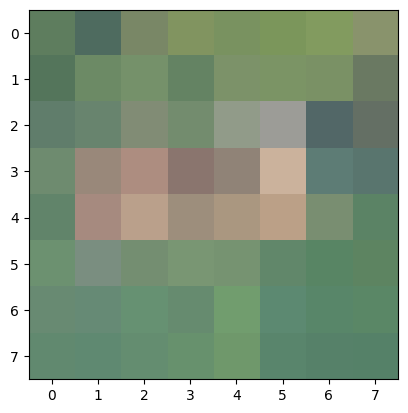

In [27]:
img = data['X_train'][index].transpose(1, 2, 0)
img = np.clip(img * 256 + 128, 0, 255).astype(np.uint8)
plt.imshow(img);

## **Data Analysis:** Bin Classification

#### RGB to LAB Color Space Conversion

In [28]:
data['X_train'] = data['X_train'].transpose(0, 2, 3, 1)             # (N, C, H, W) -> (N, H, W, C)
data['X_train'] = (data['X_train'] * 256 + 128).astype(np.uint8)    # un-normalize
data['X_train'].shape

(256232, 8, 8, 3)

In [29]:
def rgb_to_lab(img_batch):
    N, H, W, C = img_batch.shape
    if C != 3:
        raise ValueError('Expected the last dimension to be 3 (RGB channels).')
    
    L_batch = []
    a_batch = []
    b_batch = []

    for i in range(N):
        lab_img = cv.cvtColor(img_batch[i], cv.COLOR_RGB2LAB)
        L, a, b = cv.split(lab_img)

        L = L * 100 / 255                   # Scale L to [0, 100]   
        a = a.astype(np.int16) - 128        # Scale a to [-128, 127]
        b = b.astype(np.int16) - 128        # Scale b to [-128, 127]

        L_batch.append(L)
        a_batch.append(a)
        b_batch.append(b)

    L_batch = np.array(L_batch, dtype=np.float16)
    a_batch = np.array(a_batch, dtype=np.float16)
    b_batch = np.array(b_batch, dtype=np.float16)

    return L_batch, a_batch, b_batch
    
L_batch, a_batch, b_batch = rgb_to_lab(data['X_train'])
L_batch.shape, a_batch.shape, b_batch.shape

((256232, 8, 8), (256232, 8, 8), (256232, 8, 8))

In [30]:
def merge_ab(L_batch, a_batch, b_batch):
    N, H, W = L_batch.shape
    ab_batch = np.stack((a_batch, b_batch), axis=-1)

    return L_batch, ab_batch

L_batch, ab_batch = merge_ab(L_batch, a_batch, b_batch)
L_batch.shape, ab_batch.shape

((256232, 8, 8), (256232, 8, 8, 2))

#### Pixel-Level Analysis

In [31]:
ab_batch_flat = ab_batch.reshape(-1, 2)
ab_batch_flat.shape    # (N * H * W, 2)

(16398848, 2)

#### **Cumulative Run:** Aggregation

In [32]:
def get_bin_counts(data, bin_counts, ab_bins, img_size=img_size, ix=0):
    data['X_train'] = data['X_train'] * 256 + 128
    data['X_train'] = data['X_train'].transpose(0, 2, 3, 1)
    data['X_train'] = np.clip(data['X_train'], 0, 255).astype(np.uint8)
    
    L_batch, a_batch, b_batch = rgb_to_lab(data['X_train'])
    L_batch, ab_batch = merge_ab(L_batch, a_batch, b_batch)
    ab_batch_flat = ab_batch.reshape(-1, 2)

    num_pixels = ab_batch_flat.shape[0]
    print(f'Number of pixels: {num_pixels} in {L_batch.shape[0]} images at {img_size}x{img_size} resolution.')
    
    for i in range(num_pixels):
        if i % L_batch.shape[0] == 0:
            print(f'Processing pixel {i:,}/{num_pixels:,}... in batch {ix+1}')
        torch_ab = torch.tensor(ab_batch_flat[i])
        distance_key, _ = k_nearest_neighbours(torch_ab, ab_bins, 1)
        nearest_bin = (ab_bins[distance_key[0]][0].item(), ab_bins[distance_key[0]][1].item())
        bin_counts[nearest_bin] = bin_counts.get(nearest_bin, 0) + 1

    return bin_counts, num_pixels

In [33]:
pixel_count = 0
bin_counts = {}

for ix in range(10):
    print('Extracting data from batch:', ix+1)
    print('---------------------------------')
    data = extract_arrays(ix+1, img_size)
    bin_count_i, pixel_count_i = get_bin_counts(data, bin_counts, ab_bins, img_size, ix)
    pixel_count += pixel_count_i
    print('Extracted data from batch:', ix+1)
    print('---------------------------------')

print(f'Total pixels processed: {pixel_count}')

Extracting data from batch: 1
---------------------------------
Number of pixels: 16398848 in 256232 images at 8x8 resolution.
Processing pixel 0/16,398,848... in batch 1
Processing pixel 256,232/16,398,848... in batch 1
Processing pixel 512,464/16,398,848... in batch 1
Processing pixel 768,696/16,398,848... in batch 1
Processing pixel 1,024,928/16,398,848... in batch 1
Processing pixel 1,281,160/16,398,848... in batch 1
Processing pixel 1,537,392/16,398,848... in batch 1
Processing pixel 1,793,624/16,398,848... in batch 1
Processing pixel 2,049,856/16,398,848... in batch 1
Processing pixel 2,306,088/16,398,848... in batch 1
Processing pixel 2,562,320/16,398,848... in batch 1
Processing pixel 2,818,552/16,398,848... in batch 1
Processing pixel 3,074,784/16,398,848... in batch 1
Processing pixel 3,331,016/16,398,848... in batch 1
Processing pixel 3,587,248/16,398,848... in batch 1
Processing pixel 3,843,480/16,398,848... in batch 1
Processing pixel 4,099,712/16,398,848... in batch 1
Pro

In [34]:
bin_counts

{(8.0, -8.0): 42741440,
 (8.0, 8.0): 25475800,
 (8.0, 24.0): 5837374,
 (24.0, 24.0): 1744106,
 (24.0, 8.0): 2301042,
 (24.0, -8.0): 1023926,
 (-8.0, -8.0): 36324150,
 (-8.0, 8.0): 16929304,
 (-24.0, 24.0): 3062884,
 (-8.0, 24.0): 4667320,
 (-24.0, 8.0): 1609126,
 (-24.0, 40.0): 1196850,
 (-8.0, 40.0): 927630,
 (-8.0, -24.0): 4198274,
 (8.0, -24.0): 4891594,
 (56.0, 24.0): 259270,
 (40.0, 24.0): 536994,
 (40.0, 8.0): 545610,
 (-24.0, 56.0): 232440,
 (-8.0, 56.0): 242888,
 (-40.0, 56.0): 128604,
 (-40.0, 40.0): 359904,
 (-8.0, -56.0): 35810,
 (8.0, -40.0): 1555056,
 (8.0, -56.0): 338492,
 (-8.0, -40.0): 665744,
 (24.0, -72.0): 67274,
 (24.0, -56.0): 210084,
 (24.0, -40.0): 220030,
 (24.0, -24.0): 259174,
 (40.0, -8.0): 171472,
 (40.0, 40.0): 246790,
 (8.0, 40.0): 1229766,
 (8.0, 56.0): 269320,
 (24.0, 56.0): 196142,
 (-24.0, -24.0): 265900,
 (-24.0, -8.0): 568494,
 (24.0, 40.0): 716248,
 (40.0, -56.0): 42952,
 (40.0, -72.0): 51718,
 (56.0, -8.0): 44450,
 (56.0, 8.0): 118476,
 (40.0, -40.

#### **Cumulative Run:** Visualization

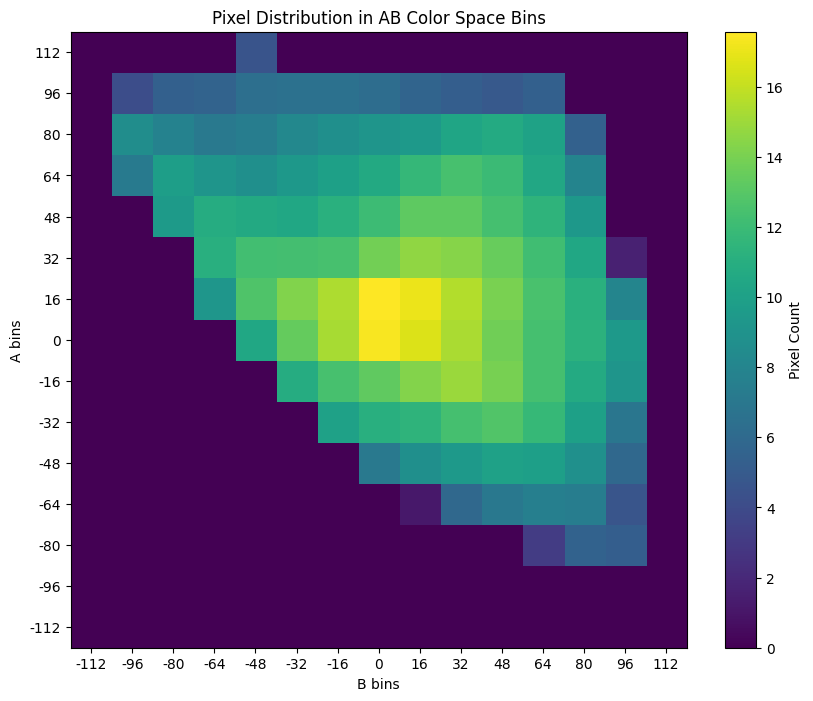

In [35]:
a_range = np.arange(-128 + grid_size, 128, grid_size)
b_range = np.arange(-128 + grid_size, 128, grid_size)
heatmap = np.zeros((len(a_range), len(b_range)))

for (a, b), count in bin_counts.items():
    a_index = int((a + 128) // grid_size)  
    b_index = int((b + 128) // grid_size)
    heatmap[a_index, b_index] += count

# log transform to make the heatmap more interpretable (ln(1+x))
log_heatmap = np.log1p(heatmap)    

plt.figure(figsize=(10, 8))
plt.imshow(log_heatmap, origin='lower', aspect='equal', interpolation='nearest')

cbar = plt.colorbar()
cbar.set_label('Pixel Count')

plt.title('Pixel Distribution in AB Color Space Bins')
plt.xlabel('B bins')
plt.ylabel('A bins')
plt.xticks(ticks=np.arange(len(b_range)), labels=b_range)
plt.yticks(ticks=np.arange(len(a_range)), labels=a_range)

plt.show();